In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import pandas_market_calendars as mcal

In [2]:
def nyse_holidays():
    nyse = mcal.get_calendar('NYSE')
    holidays = nyse.holidays()
    nyse_holidays = holidays.holidays
    
    return nyse_holidays

# shift dates if they fall on a weekend/trading holiday
def get_prev_business_date(date, holidays):
    if date.isoweekday() in set((6, 7)):
        #if date falls on a weekend, move the date back
        date -= pd.offsets.BDay(n = date.isoweekday() % 5)
    elif date in holidays:
        #if date is a NYSE trading holiday, move the date back
        date -= pd.offsets.BDay(n=1)  # get prev day
        # now if the new date is on a weekend, move it back 
        if date.isoweekday() in set((6, 7)):
            date -= pd.offsets.BDay(n = date.isoweekday() % 5)

    return date

In [3]:
#Load Price Data
wd = os.getcwd()

df = pd.read_excel(wd+'/Data/'+'WTI.xlsx')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%m-%d-%Y')
df.set_index('Date', inplace=True)

In [4]:
#Load Features

xlsx_files = glob.glob(os.path.join(wd, 'Data', "*.xlsx"))
holidays = nyse_holidays()
daily_data = ['DowJones', 'SPX', 'USDEUR', 'DAX', 'NG1', 'Nikkei', 'HangSeng', 'GT10']

for file in xlsx_files:
    data_name = file.split("\\")[-1].split('.')[0]
    data_name = data_name.replace(" ", "_")
    
    if data_name == 'WTI':
        continue
        
    df_temp = pd.read_excel(file)
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    #print(data_name)
    if data_name in daily_data:
        df_temp['Date'] = df_temp['Date'].dt.strftime('%m-%d-%Y')
        df_temp.set_index('Date', inplace=True)
    else:
        df_temp['Artificial Date'] = df_temp['Date'].apply(lambda x: get_prev_business_date(x, holidays))
        df_temp['Artificial Date'] = df_temp['Artificial Date'].dt.strftime('%m-%d-%Y')
        df_temp = df_temp.drop(columns=['Date'])
        df_temp.set_index('Artificial Date', inplace=True)
    
    try:
        df[df_temp.columns[0] + '_' + data_name] = df_temp[df_temp.columns[0]]
    except ValueError:
        print(data_name, "Error")

#backfill data for other frequencies
df.fillna(method='bfill', inplace=True)
idx = list(df.index).index('12-31-2020')
df = df.iloc[idx:,:]

In [5]:
#Add Sign and returns Data point
df['PX_Sign'] = np.sign(df['PX_LAST'] - df['PX_LAST'].shift(-1))
df.loc[df.PX_Sign == 0, 'PX_Sign'] = int(1)
df['Returns'] = df['PX_LAST']/df['PX_LAST'].shift(-1) - 1

c:\users\joel\appdata\local\programs\python\python37\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
df

,PX_LAST,PX_VOLUME,PX_LAST_Canada_daily_prod,PX_LAST_Cass_Freight_Rates,PX_LAST_China_GDP,PX_LAST_DAX,PX_LAST_DowJones,PX_LAST_Europe_Inflation,PX_LAST_Europe_IndProd_exConstruction,PX_LAST_Germany_GDP,...,PX_LAST_Russia_Industrial_Production,PX_LAST_Russia_daily_prod,PX_LAST_SPX,PX_LAST_US_GDP,PX_LAST_US_Inflation,PX_LAST_USDEUR,PX_LAST_US_daily_prod,PX_LAST_US_IndProd_Index,PX_Sign,Returns
Date,,,,,,,,,,,,,,,,,,,,,
12-31-2020,48.52,181894.0,4643.0,1.122,6.5,13718.78,30606.48,-0.3,101.8,-3.3,...,3.8,9654.725,3756.07,-1.0,1.4,0.8186,11063.097,98.2854,1.0,0.002479
12-30-2020,48.40,266957.0,4490.0,1.154,4.9,13718.78,30409.56,-0.3,101.8,-3.8,...,-1.0,9621.970,3732.04,-1.7,1.2,0.8130,11121.033,97.1609,1.0,0.008333
12-29-2020,48.00,213778.0,4490.0,1.154,4.9,13761.38,30335.67,-0.3,101.8,-3.8,...,-1.0,9621.970,3727.04,-1.7,1.2,0.8163,11121.033,97.1609,1.0,0.007980
12-28-2020,47.62,238462.0,4490.0,1.154,4.9,13790.29,30403.97,-0.3,101.8,-3.8,...,-1.0,9621.970,3735.36,-1.7,1.2,0.8187,11121.033,97.1609,-1.0,-0.012648
12-24-2020,48.23,167390.0,4490.0,1.154,4.9,13587.23,30199.87,-0.3,101.8,-3.8,...,-1.0,9621.970,3703.06,-1.7,1.2,0.8206,11121.033,97.1609,1.0,0.002286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08-01-1990,21.62,38007.0,NaN,NaN,NaN,1892.89,2899.26,NaN,NaN,NaN,...,NaN,NaN,355.52,NaN,NaN,0.7566,NaN,NaN,-1.0,-0.063258
05-01-1990,23.08,50.0,NaN,NaN,NaN,1787.87,2668.92,NaN,NaN,NaN,...,NaN,NaN,332.25,NaN,NaN,0.8003,NaN,NaN,-1.0,-0.014097
04-01-1990,23.41,2500.0,NaN,NaN,NaN,1787.87,2635.59,NaN,NaN,NaN,...,NaN,NaN,332.74,NaN,NaN,0.8175,NaN,NaN,-1.0,-0.011402


Text(0.5, 1.0, 'WTI Price (1990-2021)')

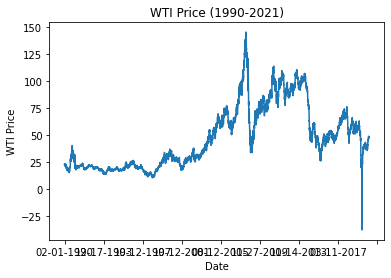

In [7]:
df_t = df.copy()
ax = df_t[df_t.columns[0]][::-1].plot()
ax.set_ylabel("WTI Price")
ax.set_title('WTI Price (1990-2021)')

In [8]:
prices = ['PX_LAST']
classification = ['PX_Sign']
returns = ['Returns']

In [9]:
#Dict for frequency adjustment
cols_freq = {
    'PX_LAST':"daily",
    'PX_VOLUME':"daily",
    'PX_LAST_DowJones':"daily",
    'PX_MID_GT10':"daily",
    'PX_LAST_HangSeng':"daily",
    'PX_LAST_Nikkei':"daily",
    'PX_LAST_SPX':"daily",
    'PX_LAST_USDEUR':"daily",
    'PX_LAST_NG1':"daily",
    'PX_LAST_DAX':"daily",
    'PX_LAST_US_daily_prod':"monthly",
    'PX_LAST_Cass_Freight_Rates':"monthly",
    'PX_LAST_Canada_daily_prod':"monthly",
    'PX_LAST_Russia_daily_prod':"monthly",
    'PX_LAST_OPEC_daily_prod':"monthly",
    'PX_LAST_US_Inflation':"monthly",
    'PX_LAST_Europe_Inflation':"monthly",
    'PX_LAST_Europe_IndProd_exConstruction':"monthly",
    'PX_LAST_Russia_Industrial_Production':"monthly",
    'PX_LAST_US_IndProd_Index':"monthly",
    'PX_LAST_China_GDP':"quarterly",
    'PX_LAST_Germany_GDP':"quarterly",
    'PX_LAST_Japan_GDP':"quarterly",
    'PX_LAST_Russia_GDP':"quarterly",
    'PX_LAST_US_GDP':"quarterly",
    'PX_Sign':'daily',
    'Returns':'daily'
}

In [10]:
def daily_lag(df, column, lag):
    lag = lag+1
    if column==0:
        for i in range(1, lag):
            #creating new column here since column==0 is target
            
            df[df.columns[column] + '_t-' + str(i)] = df[df.columns[column]].shift(-i)
            cols_freq[df.columns[column]+'_t-'+str(i)] = "daily"
    else:
        for i in range(1, lag):
            #replacing old column here and renaming
            df[df.columns[column]] = df[df.columns[column]].shift(-i)
            df.rename(columns={df.columns[column]:df.columns[column]+'_t-'+str(i)}, inplace=True)
            new_col = df.columns[column]
            cols_freq[new_col] = "daily"
    
    return df


def ma(df, column, freq = "monthly"):
    if freq == "monthly":
        #creating temp column to get values
        df[df.columns[column] + '_temp'] = df[df.columns[column]]
        
        for i in range(0, len(df[df.columns[column]])-22):
            df.iloc[i, column] = np.mean(df.iloc[i:i+22, -1])
        
        #dropping temp column
        drop_col_name = df.columns[column] + '_temp'
        df = df.loc[:, ~df.columns.isin([drop_col_name])]
        
        #renaming column to indicate moving average
        df.rename(columns={df.columns[column]:df.columns[column]+'_SMA22'}, inplace=True)
        cols_freq[df.columns[column]] = "monthly"
    elif freq == "quarterly":
        #creating temp column to get values
        df[df.columns[column] + '_temp'] = df[df.columns[column]]
        
        for i in range(0, len(df[df.columns[column]])-65):
            df.iloc[i, column] = np.mean(df.iloc[i:i+65, -1])
        
        #dropping temp column
        drop_col_name = df.columns[column] + '_temp'
        df = df.loc[:, ~df.columns.isin([drop_col_name])]
        
        #renaming column to indicate moving average
        df.rename(columns={df.columns[column]:df.columns[column]+'_SMA65'}, inplace=True)
        cols_freq[df.columns[column]] = "quarterly"
    
    return df


def lag_data(df, column, freq = "monthly"):
    if freq == "monthly":
        #replacing old column and renaming
        df[df.columns[column]] = df[df.columns[column]].shift(-22)
        df.rename(columns={df.columns[column]:df.columns[column]+'_M'}, inplace=True)
    elif freq == "quarterly":
        #replacing old column and renaming
        df[df.columns[column]] = df[df.columns[column]].shift(-65)
        df.rename(columns={df.columns[column]:df.columns[column]+'_Q'}, inplace=True)
    elif freq == "weekly":
        #replacing old column and renaming
        df[df.columns[column]] = df[df.columns[column]].shift(-10)
        df.rename(columns={df.columns[column]:df.columns[column]+'_W'}, inplace=True)
    else:
        raise ValueError("Frequency invalid")
    
    return df

def get_lag_ma_data(df, daily_lags = 1, cols_freq=cols_freq):
    for i in range(len(df.columns)):
        column_name = df.columns[i]
        #print(column_name)
        if cols_freq[column_name] == 'daily':
            df = daily_lag(df, i, daily_lags)
        else:
            df = lag_data(df, i, cols_freq[column_name])
            df = ma(df, i, cols_freq[column_name])
            
    return df

In [11]:
def one_day_change(df, column):
    #creating new column here, will drop old column later in get_diffs
    df[df.columns[column] + '_1D_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-1)
    return df

def two_week_change(df, column):
    #creating new column here, will drop old column later in get_diffs
    df[df.columns[column] + '_2W_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-10)
    return df

def one_month_change(df, column):
    #creating new column here, will drop old column later in get_diffs
    df[df.columns[column] + '_1M_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-22)
    return df

def get_diffs(df, target, cols_freq=cols_freq, drop=True):
    cols = []
    for i in range(1, len(df.columns)):
        column_name = df.columns[i]
        #collecting old columns to drop later
        cols.append(column_name)
        
        if cols_freq[column_name] == 'daily':
            df = one_day_change(df, i)
            df = two_week_change(df, i)
            df = one_month_change(df, i)
        elif cols_freq[column_name] == 'monthly':
            df = two_week_change(df, i)
            df = one_month_change(df, i)
        elif cols_freq[column_name] == 'quarterly':
            df = one_month_change(df, i)
        
    #dropping old columns
    target_lagged = df.columns[0] + '_t-1'
    cols.remove(target_lagged)
    #print(cols)
    df = df.loc[:, ~df.columns.isin(cols)]
    
    return df

In [12]:
def make_regime(df, end, start=0):
    if start==0 and end==0:
        return df
    
    if start!=0:
        st_idx = list(df.index).index(start)
    else:
        st_idx = 0
    end_idx = list(df.index).index(end)
    df_reg = df.iloc[st_idx:end_idx,:]
    return df_reg

In [13]:
def get_final_data(df, features, regime, target=classification):
    if target != prices:
        features = ['PX_LAST'] + features
    
    df_trial = get_lag_ma_data(df[target + features])
    df_trial = get_diffs(df_trial, target)
    
    df_trial = df_trial.dropna()
    df_trial = df_trial[::-1]
    
    df_reg = make_regime(df_trial, end=regime[1], start=regime[0])
    
    df_target = df_reg[target]
    df_features = df_reg.iloc[:, 1:]
    
    return df_target, df_features

In [14]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit

def get_data_splits(target, features):
    train_n = int(len(target) * 0.8)
    train_x = features[:train_n].to_numpy()
    train_y = target[:train_n].to_numpy()
    test_x = features[train_n:].to_numpy()
    test_y = target[train_n:].to_numpy()

    splits = TimeSeriesSplit(n_splits=100)

    split_train_x = []
    split_val_x = []
    split_train_y = []
    split_val_y = []

    for train_index, val_index in splits.split(train_x):
        split_train_x.append(train_x[train_index])
        split_train_y.append(train_y[train_index])
        split_val_x.append(train_x[val_index])
        split_val_y.append(train_y[val_index])
        
    split_data = [split_train_x, split_train_y, split_val_x, split_val_y]
    train_data = [train_x, train_y]
    test_data = [test_x, test_y]
    
    return split_data, train_data, test_data

In [15]:
def lasso(split_data):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    alphas = np.arange(0.05, 1.01, 0.05)
    alpha_mse = []
    
    for alpha in alphas:
        transformer = RobustScaler
        model = linear_model.Lasso(alpha=alpha)
        mse = []
        for i in range(len(split_train_x)):
            wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
            wrapped_model.fit(split_train_x[i], split_train_y[i])
            yhat = wrapped_model.predict(split_val_x[i])
            mse.append(np.mean((yhat-split_val_y[i])**2))
        alpha_mse.append(np.mean(mse))
    a_star = alphas[np.argmin(alpha_mse)]
    print('Alpha* = {}'.format(alphas[np.argmin(alpha_mse)]))
    return alpha_mse, a_star

def lasso_test(train_data, test_data, alpha):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = linear_model.Lasso(alpha=alpha)
    wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
    wrapped_model.fit(train_x, train_y)
    pred = wrapped_model.predict(test_x)
    mse = np.mean((pred-test_y)**2)
    
    return pred, mse

In [16]:
def huber(split_data):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    alphas = np.arange(0.05, 1.01, 0.05)
    alpha_mse = []
    
    for alpha in alphas:                     
        transformer = RobustScaler
        model = linear_model.HuberRegressor(alpha=alpha)
        mse = []
        for i in range(len(split_train_x)):
            wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
            wrapped_model.fit(split_train_x[i], split_train_y[i])
            yhat = wrapped_model.predict(split_val_x[i])
            mse.append(np.mean((yhat-split_val_y[i])**2))
        alpha_mse.append(np.mean(mse))
    a_star = alphas[np.argmin(alpha_mse)]
    print('Alpha* = {}'.format(a_star))
    return alpha_mse, a_star

def huber_test(train_data, test_data, alpha):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = linear_model.HuberRegressor(alpha=alpha)
    wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
    wrapped_model.fit(train_x, train_y)
    pred = wrapped_model.predict(test_x)
    mse = np.mean((pred-test_y)**2)
    
    return pred, mse

In [17]:
from sklearn.ensemble import RandomForestRegressor

def RF_regressor(split_data):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    estimators = np.arange(950, 1000, 10)
    estimator_mse = []
    
    for estimator in estimators:
        model = RandomForestRegressor(n_estimators=estimator)
        mse = []
        model.fit(split_train_x[-1], split_train_y[-1])
        yhat = model.predict(split_val_x[-1])
        mse.append(np.mean((yhat-split_val_y[-1])**2))
        estimator_mse.append(np.mean(mse))
    best_est = estimators[np.argmin(estimator_mse)]
    print('Efficient Estimator = {}'.format(best_est))
    return estimator_mse, best_est

def RF_regressor_test(train_data, test_data, best_est):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = RandomForestRegressor(n_estimators=best_est)
    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    mse = np.mean((pred-test_y)**2)
    
    return pred, mse

In [35]:
import xgboost as xgb

def XGBoost(split_data):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    estimators = np.arange(10, 101, 10)
    estimator_mse = []
    
    for estimator in estimators:
        print('val for est=',estimator)
        transformer = RobustScaler
        model = xgb.XGBRegressor(n_estimators=estimator, subsample=1.0)
        mse = []
        
        for i in range(len(split_train_x)):
            wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
            wrapped_model.fit(split_train_x[i], split_train_y[i])
            yhat = wrapped_model.predict(split_val_x[i])
            mse.append(np.mean((yhat-split_val_y[i])**2))
        estimator_mse.append(np.mean(mse))
    best_est = estimators[np.argmin(estimator_mse)]
    print('Efficient Estimator = {}'.format(best_est))
    return estimator_mse, best_est

def XGBoost_test(train_data, test_data, best_est):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = xgb.XGBRegressor(n_estimators=best_est, subsample=1.0)
    model.fit(train_x, train_y)
    pred = wrapped_model.predict(test_x)
    mse = np.mean((pred-test_y)**2)
    
    return pred, mse

In [19]:
# Feature Categories by Type
fin_indices = ['PX_LAST_DAX', 'PX_LAST_DowJones', 'PX_MID_GT10',
           'PX_LAST_HangSeng', 'PX_LAST_Nikkei', 'PX_LAST_SPX',
           'PX_LAST_USDEUR']
nat_gas = ['PX_LAST_NG1']
gdp = ['PX_LAST_China_GDP', 'PX_LAST_Germany_GDP', 'PX_LAST_Japan_GDP',
       'PX_LAST_Russia_GDP', 'PX_LAST_US_GDP']
oil_prod = ['PX_LAST_Canada_daily_prod', 'PX_LAST_Russia_daily_prod',
            'PX_LAST_OPEC_daily_prod', 'PX_LAST_US_daily_prod']
freight = ['PX_LAST_Cass_Freight_Rates']
inflation = ['PX_LAST_US_Inflation', 'PX_LAST_Europe_Inflation']
ind_prod = ['PX_LAST_Europe_IndProd_exConstruction', 
            'PX_LAST_Russia_Industrial_Production',
            'PX_LAST_US_IndProd_Index']

In [20]:
# Feature Categories by Date Range
feat_1992 = ['PX_LAST_DAX', 'PX_LAST_DowJones', 'PX_MID_GT10', 
             'PX_LAST_HangSeng', 'PX_LAST_Nikkei', 'PX_LAST_SPX', 
             'PX_LAST_USDEUR', 'PX_LAST_NG1', 'PX_LAST_China_GDP', 
             'PX_LAST_Germany_GDP', 'PX_LAST_US_GDP', 'PX_LAST_US_daily_prod', 
             'PX_LAST_Cass_Freight_Rates', 'PX_LAST_US_Inflation', 
             'PX_LAST_Europe_IndProd_exConstruction', 'PX_LAST_US_IndProd_Index']
feat_1996 = feat_1992 + ['PX_LAST_Japan_GDP', 'PX_LAST_Russia_GDP',
                         'PX_LAST_Canada_daily_prod', 'PX_LAST_Russia_daily_prod']
feat_2000 = feat_1996 + ['PX_LAST_OPEC_daily_prod', 'PX_LAST_Europe_Inflation']
feat_2002 = feat_2000 + ['PX_LAST_Russia_Industrial_Production']

In [21]:
reg_92_99 = [0, '12-30-1999']
reg_00_06 = ['04-03-2000', '12-29-2006']
reg_07_12 = ['01-02-2007', '12-31-2012']
reg_13_20 = ['01-02-2013', '12-31-2020']
no_regime = [0, 0]

### Meta Learning

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
df_m = df_t.copy()
features = feat_2002
regime = no_regime

meta_target, meta_features = get_final_data(df=df_m,
                                           features=features,
                                           regime=regime,
                                           target=prices)

In [24]:
from sklearn.tree import DecisionTreeClassifier

def meta_split(target, features):
    split_1 = int(len(target) * 0.5)
    split_2 = int(len(target) * 0.75)
    
    train_X = features[:split_1].to_numpy()
    train_y = target[:split_1].to_numpy()
    val_X = features[split_1:split_2].to_numpy()
    val_y = target[split_1:split_2].to_numpy()
    test_X = features[split_2:].to_numpy()
    test_y = target[split_2:].to_numpy()
    
    train_data = [train_X, train_y, val_X, val_y]
    test_data = [test_X, test_y]
    
    return train_data, test_data

In [25]:
meta_train, meta_test = meta_split(meta_target, meta_features)

In [26]:
hyper = []
meta_prep_split, meta_prep_train, meta_prep_test = get_data_splits(meta_target, meta_features)

### Run from here

In [27]:
meta_lasso_mse, meta_lasso_alpha = lasso(meta_prep_split)

Alpha* = 0.05


In [28]:
meta_huber_mse, meta_huber_alpha = huber(meta_prep_split)

Alpha* = 0.9000000000000001


In [29]:
meta_rf_mse, meta_rf_best_est = RF_regressor(meta_prep_split)

Efficient Estimator = 990


In [36]:
meta_xgb_mse, meta_xgb_best_est = XGBoost(meta_prep_split)

val for est= 10
val for est= 20
val for est= 30
val for est= 40
val for est= 50
val for est= 60
val for est= 70
val for est= 80
val for est= 90
val for est= 100
Efficient Estimator = 20


In [37]:
hyper.append(meta_lasso_alpha)
hyper.append(meta_huber_alpha)
hyper.append(meta_rf_best_est)
hyper.append(meta_xgb_best_est)

In [81]:
train_x = meta_train[0]
train_y = meta_train[1]
val_x = meta_train[2]
val_y = meta_train[3]
    
test_x = meta_test[0]
test_y = meta_test[1]

In [74]:
models_meta = []

In [75]:
lasso = linear_model.Lasso(alpha=meta_lasso_alpha)
models_meta.append(TransformedTargetRegressor(regressor=lasso, transformer=RobustScaler()))
models_meta[0].fit(train_x, train_y)

TransformedTargetRegressor(regressor=Lasso(alpha=0.05),
                           transformer=RobustScaler())

In [42]:
# huber = linear_model.HuberRegressor(alpha=meta_huber_alpha)
# models_meta.append(TransformedTargetRegressor(regressor=huber, transformer=RobustScaler()))
# models_meta[1].fit(train_x, train_y)

TransformedTargetRegressor(regressor=HuberRegressor(alpha=0.9000000000000001),
                           transformer=RobustScaler())

In [76]:
models_meta.append(RandomForestRegressor(n_estimators=meta_rf_best_est))
models_meta[1].fit(train_x, train_y)

RandomForestRegressor(n_estimators=990)

In [77]:
xgb_reg = xgb.XGBRegressor(n_estimators=meta_xgb_best_est, subsample=1.0)
models_meta.append(TransformedTargetRegressor(regressor=xgb_reg, transformer=RobustScaler()))
models_meta[2].fit(train_x, train_y)

TransformedTargetRegressor(regressor=XGBRegressor(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  gamma=None, gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  

In [87]:
model_num = []
for i, x in enumerate(val_x):
    err = []
    for model in models_meta:
#         print(model)
        yhat = model.predict(x.reshape(1,-1))
        err.append((yhat-val_y[i])**2)
    model_num.append((np.argmin(err)))


In [88]:
for i in range(len(models_meta)):
    print('Count of ', i, ' is ', model_num.count(i))

Count of  0  is  523
Count of  1  is  355
Count of  2  is  301


In [89]:
model_label = np.array(model_num)

In [90]:
#to choose best model for datapoint:
    
split = int(0.75*len(val_x))
t_train_X = val_x[:split]
t_train_y = model_label[:split]
t_val_X = val_x[split:]
t_val_y = model_label[split:]

In [91]:
depths = np.arange(2, 10, 1)
scores = []
for depth in depths:
    dtree_model = DecisionTreeClassifier(max_depth = depth).fit(t_train_X, t_train_y)
    dtree_score = dtree_model.score(t_val_X, t_val_y)
    scores.append(dtree_score)
    
best_depth = depths[np.argmax(scores)]
print('Best depth: ', best_depth)

Best depth:  4


In [100]:
scores

[0.3593220338983051,
 0.3728813559322034,
 0.38305084745762713,
 0.31864406779661014,
 0.34915254237288135,
 0.36610169491525424,
 0.3423728813559322,
 0.3423728813559322]

In [92]:
dtree_final = DecisionTreeClassifier(max_depth=best_depth).fit(val_x, model_label)
model_pred = dtree_final.predict(test_x)

In [99]:
for i in range(len(models_meta)):
    print('Count of ', i, ' is ', list(model_pred).count(i))

Count of  0  is  806
Count of  1  is  304
Count of  2  is  70


In [93]:
meta_preds = []
for i, x in enumerate(test_x):
    pred = models_meta[model_pred[i]].predict(x.reshape(1,-1))
    meta_preds.append(pred)

meta_mse = np.mean((meta_preds-test_y)**2)

In [94]:
meta_rmse = np.sqrt(meta_mse)
print("Meta Learning RMSE = ", meta_rmse)

Meta Learning RMSE =  2.519051956727933


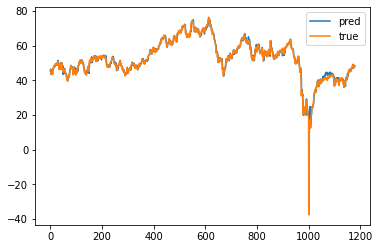

In [95]:
plt.plot(meta_preds, label='pred')
plt.plot(test_y, label='true')
plt.legend()

(-20.0, 40.0)

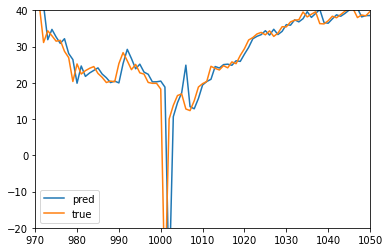

In [102]:
plt.plot(meta_preds, label='pred')
plt.plot(test_y, label='true')
plt.legend()
plt.xlim(970,1050)
plt.ylim(-20,40)

### Stacking

In [ ]:
df_m = df_t.copy()
features = feat_2002
regime = no_regime

stack_target, stack_features = get_final_data(df=df_m,
                                           features=features,
                                           regime=regime,
                                           target=prices)

In [ ]:
stack_split, stack_train, stack_test = get_data_splits(stack_target, stack_features)

In [ ]:
from sklearn.ensemble import StackingRegressor

st_train_x = stack_train[0]
st_train_y = stack_train[1]
st_test_x = stack_test[0]
st_test_y = stack_test[1]

Here using hyperparameters for full data that we got earlier above, if we need to run for each regime, will have to get those hyperparameters again for each. 
Don't run the immediately next block for now, but run the one after that to set stack_hyper params

In [ ]:
stack_lasso_mse, stack_lasso_alpha = lasso(stack_split)
stack_huber_mse, stack_huber_alpha = huber(stack_split)
stack_rf_mse, stack_rf_best_est = RF_regressor(stack_split)
stack_xgb_mse, stack_xgb_best_est = XGBoost(stack_split)

In [ ]:
stack_lasso_alpha = meta_lasso_alpha
stack_huber_alpha = meta_huber_alpha
stack_rf_best_est = meta_rf_best_est
stack_xgb_best_est = meta_xgb_best_est

In [ ]:
level0 = list()
level0.append(('xgb', TransformedTargetRegressor(regressor=xgb.XGBRegressor(n_estimators=stack_xgb_best_est, subsample=1.0)
                                                 , transformer=RobustScaler())))
level0.append(('rf', TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=stack_rf_best_est), transformer=RobustScaler())))
level0.append(('huber', TransformedTargetRegressor(regressor=linear_model.HuberRegressor(alpha=stack_huber_alpha), transformer=RobustScaler())))
level0.append(('lasso', TransformedTargetRegressor(regressor=linear_model.Lasso(alpha=stack_lasso_alpha), transformer=RobustScaler())))
level1 = LinearRegression()

In [ ]:
stack_model = StackingRegressor(estimators=level0, final_estimator=level1)
stack_model.fit(st_train_x, st_train_y)
stack_pred = stack_model.predict(st_test_x)
stack_mse = np.mean((stack_pred - st_test_y)**2)

In [ ]:
stack_rmse = np.sqrt(stack_mse)
print("Stacking RMSE = ", stack_rmse)

In [ ]:
plt.plot(stack_pred, label='pred')
plt.plot(st_test_y, label='true')
plt.legend()